In [1]:
# загрузка библиотек
import pandas as pd
import urllib.parse as up
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

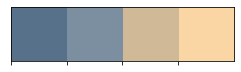

In [2]:
# задание палитры цветов
colors = ['#567189', '#7B8FA1', '#CFB997', '#FAD6A5']
sns.palplot(sns.color_palette(colors))

## 1. Подключение к базе данных

In [3]:
# загрузка конфигурации доступа к базе данных в облаке
with open('DATABASE_URL.txt', 'r') as f:
    DATABASE_URL = f.read()

In [4]:
# разбивка на компоненты
url = up.urlparse(DATABASE_URL)

In [5]:
# создание подключения к базе данны
connect = psycopg2.connect(database=url.path[1:],
                           user=url.username,
                           password=url.password,
                           host=url.hostname,
                           port=url.port)

In [6]:
# создание объекта курсора подключения к базе данных
cursor = connect.cursor()

## 2. SQL query - Business Layer

![solution_architecture](../Module01/images/solution_architecture.jpg)

![logical_model](images/logical_model.png)

In [18]:
# вывод заказов 'orders'
cursor.execute("SELECT Order_ID, Order_Date, Ship_Date, Ship_Mode, Customer_Name, Segment, \
                       Country, State, City, Postal_Code, Region, \
                       Product_Name, Sub_category, Category, \
                       Sales, Quantity, Discount, Profit, Returned, Person \
                FROM blm.orders AS ord \
                INNER JOIN blm.ship_modes USING(Ship_mode_ID) \
                INNER JOIN blm.customers AS cus USING(Customer_ID) \
                INNER JOIN blm.segments AS seg ON cus.Segment_ID = seg.Segment_ID \
                INNER JOIN blm.geos AS geo USING(Geo_ID) \
                INNER JOIN blm.regions AS reg ON geo.Region_ID = reg.Region_ID \
                INNER JOIN blm.products AS prod USING(Row_ID) \
                INNER JOIN blm.categorys AS cat ON prod.Sub_category_ID = cat.Sub_category_ID \
                INNER JOIN blm.persons AS per ON ord.Person_ID = per.Person_ID;")
orders = cursor.fetchall()

In [20]:
# преобразование в DataFrame
df = pd.DataFrame(orders, columns=[_.name for _ in cursor.description])
df.head()

,order_id,order_date,ship_date,ship_mode,customer_name,segment,country,state,city,postal_code,region,product_name,sub_category,category,sales,quantity,discount,profit,returned,person
0,CA-2019-145779,2019-05-06,2019-05-10,Standard Class,Doug Bickford,Consumer,United States,Arizona,Tucson,85705,West,Xerox 1883,Paper,Office Supplies,84.4160,4,0.20,27.4351999999999950,No,Anna Andreadi
1,CA-2017-113215,2017-09-03,2017-09-08,Standard Class,Cathy Prescott,Corporate,United States,Arizona,Tucson,85705,West,"GE 48"" Fluorescent Tube, Cool White Energy Sav...",Furnishings,Furniture,238.1520,3,0.20,89.3069999999999900,No,Anna Andreadi
2,CA-2017-147816,2017-09-24,2017-09-26,Second Class,Carlos Meador,Consumer,United States,Arizona,Tucson,85705,West,Samsung HM1900 Bluetooth Headset,Phones,Technology,35.1200,2,0.20,13.1700000000000000,No,Anna Andreadi
3,CA-2016-148040,2016-03-22,2016-03-26,Standard Class,Beth Fritzler,Corporate,United States,Arizona,Tucson,85705,West,Office Star - Mesh Screen back chair with Viny...,Chairs,Furniture,314.3520,3,0.20,-35.3646000000000100,No,Anna Andreadi
4,CA-2016-148040,2016-03-22,2016-03-26,Standard Class,Beth Fritzler,Corporate,United States,Arizona,Tucson,85705,West,Xerox 1951,Paper,Office Supplies,74.3520,3,0.20,23.2349999999999920,No,Anna Andreadi


In [21]:
# размерность данных
df.shape

(9993, 20)

In [10]:
# проверка на наличие пропусков
df.isna().sum()

Order_ID         0
Order_Date       0
Ship_Date        0
Ship_Mode        0
Customer_Name    0
Segment          0
Country          0
State            0
City             0
Postal_Code      0
Region           0
Product_Name     0
Sub_category     0
Category         0
Sales            0
Quantity         0
Discount         0
Profit           0
Returned         0
Person           0
dtype: int64

* Total Sales

In [11]:
# cумма продаж, округление до центов
cursor.execute("SELECT ROUND(SUM(Sales), 2) \
                FROM blm.orders;")
sales_sum = cursor.fetchone()[0]
sales_sum

Decimal('2296919.49')

* Total Profit

In [12]:
# cумма прибыли, округление до центов
cursor.execute("SELECT ROUND(SUM(Profit), 2) \
                FROM blm.orders;")
profit_sum = cursor.fetchone()[0]
profit_sum

Decimal('286409.08')

* Sales per Customer 

In [13]:
# сумма прибыли по покупателям, округление до центов и сортировка покупателей по убыванию суммы прибыли 
cursor.execute("SELECT ord.Customer_ID, Customer_Name, ROUND(SUM(Profit), 2) as Total_Profit \
                FROM blm.orders AS ord \
                INNER JOIN blm.customers USING(Customer_ID) \
                GROUP BY ord.Customer_ID, Customer_Name \
                ORDER BY Total_Profit DESC;")
profit_per_customer = cursor.fetchall()
df = pd.DataFrame(profit_per_customer, columns=['Customer_ID', 'Customer_Name', 'Total_Profit'])
df.head()

,Customer_ID,Customer_Name,Total_Profit
0,TC-20980,Tamara Chand,8981.32
1,RB-19360,Raymond Buch,6976.10
2,SC-20095,Sanjit Chand,5757.41
3,HL-15040,Hunter Lopez,5622.43
4,AB-10105,Adrian Barton,5444.81


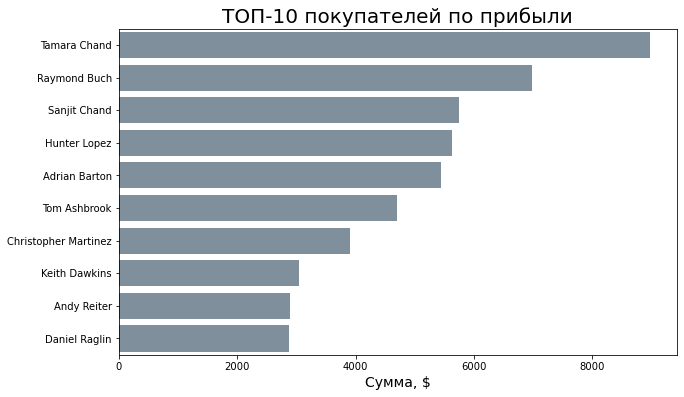

In [14]:
# визуализация ТОП-10 покупателей по прибыли
plt.figure(figsize=(10,6))
sns.barplot(data=df[:10], x='Total_Profit', y='Customer_Name', color=colors[1])
plt.title('ТОП-10 покупателей по прибыли', size = 20)
plt.xlabel('Сумма, $', size = 14)
plt.ylabel('')
plt.show()

* Monthly Sales by Segment

In [15]:
# сумма продаж в сегментах по месяцам
cursor.execute("SELECT TO_CHAR(Order_Date, 'YYYY-MM') as Date, Segment, ROUND(sum(Sales), 2) \
                FROM blm.orders \
                INNER JOIN blm.customers USING(Customer_ID) \
                INNER JOIN blm.segments USING(Segment_ID) \
                GROUP BY Date, Segment \
                ORDER BY Date, Segment;")
monthly_sales_by_segment = cursor.fetchall()
df = pd.DataFrame(monthly_sales_by_segment, columns=['Order_Date', 'Segment', 'Total_Sales'])
df.head()

,Order_Date,Segment,Total_Sales
0,2016-01,Consumer,6927.82
1,2016-01,Corporate,1701.53
2,2016-01,Home Office,5607.55
3,2016-02,Consumer,3167.85
4,2016-02,Corporate,1183.67


In [16]:
# преобразование данных для визуализации
df_monthly_sales_by_segment = pd.pivot_table(df, index='Order_Date', values='Total_Sales', columns='Segment')
df_monthly_sales_by_segment.head()

Segment,Consumer,Corporate,Home Office
Order_Date,,,
2016-01,6927.82,1701.53,5607.55
2016-02,3167.85,1183.67,168.37
2016-03,11869.30,11106.80,32714.91
2016-04,9108.61,14131.73,4773.63
2016-05,12819.16,9142.00,1687.12


In [17]:
# тоже самое с помощью SQL запроса
cursor.execute("SELECT DISTINCT Segment \
                FROM blm.segments;")
cursor.fetchall()

[('Home Office',), ('Consumer',), ('Corporate',)]

In [18]:
# тоже самое с помощью SQL запроса
cursor.execute("SELECT TO_CHAR(Order_Date, 'YYYY-MM') as Date, \
                       ROUND(sum(CASE WHEN Segment =  'Consumer' THEN Sales END), 2), \
                       ROUND(sum(CASE WHEN Segment =  'Corporate' THEN Sales END), 2), \
                       ROUND(sum(CASE WHEN Segment =  'Home Office' THEN Sales END), 2) \
                FROM blm.orders \
                INNER JOIN blm.customers USING(Customer_ID) \
                INNER JOIN blm.segments USING(Segment_ID) \
                GROUP BY Date \
                ORDER BY Date;")
monthly_sales_by_segment = cursor.fetchall()
df = pd.DataFrame(monthly_sales_by_segment, columns=['Order_Date', 'Consumer', 'Corporate', 'Home Office']) \
                 .set_index('Order_Date')
df.head()

,Consumer,Corporate,Home Office
Order_Date,,,
2016-01,6927.82,1701.53,5607.55
2016-02,3167.85,1183.67,168.37
2016-03,11869.30,11106.80,32714.91
2016-04,9108.61,14131.73,4773.63
2016-05,12819.16,9142.00,1687.12


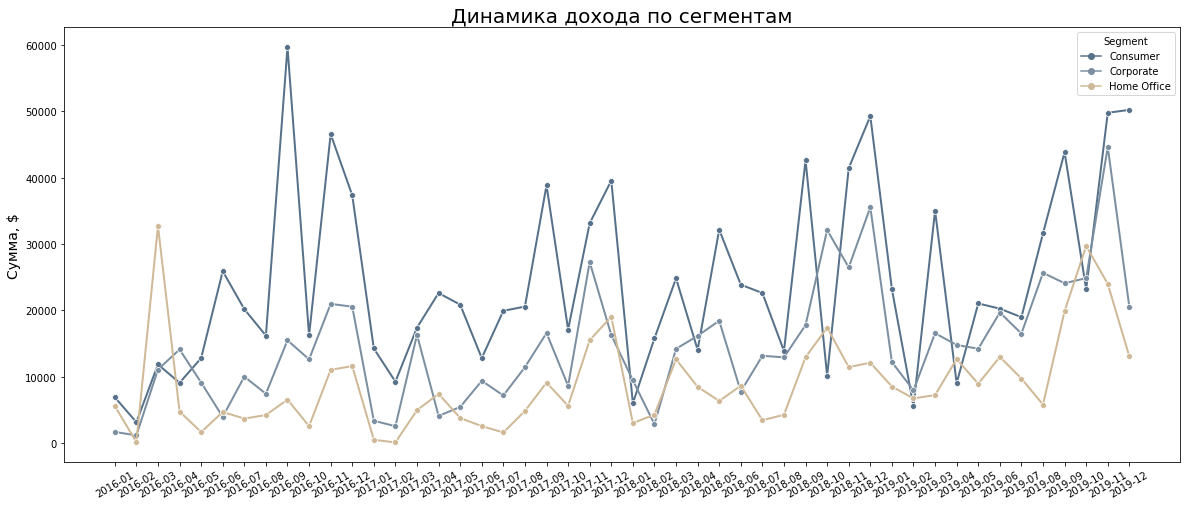

In [19]:
# визуализация динамики продаж по сегментам
plt.figure(figsize=(20,8))
sns.lineplot(data=df_monthly_sales_by_segment, dashes=False, markers=['o', 'o', 'o'], \
             lw=2, palette=sns.color_palette(colors[:3]))
plt.title('Динамика дохода по сегментам', size = 20)
plt.xlabel('')
plt.xticks(rotation=30)
plt.ylabel('Сумма, $', size = 14)
plt.show()

In [20]:
# закрытие подключения к базе данных 'postgres'
connect.close()